# Capital Asset Pricing Model

Understanding CAPM through linear regression approach, then it is just different format

In linear regression:
y = b + b1(x) + e
- y is dependent value
- b is the y intercept
- b1 is the slope. (from the perspective of graph, from the perspective of formula, it is b1, from practical meaning, it is when the IV change 1 unit, then the DV will change b1 unit)
- x is the independent value, also the predictor
- e is the error terms

In CAPM terms:
return of asseti = aplha + beta(market return) + error term
- alpha is the y intercept
- beta is the slope
- market return is the benchmark, can choose disecrete index

Generally, beta info in Yahoo Finance doesnt consider the risk-free rate, if consider, it would be:
return of asseti - rf = aplha + beta(market return-rf) + error term

Definition of Beta:

- b1=covariance(asseti return, market return)/variance of market return

- 0<beta<1, assets move in the same direction, lesser amount

- -1<beta<0, move in oppositie direction, lesser amount

- Reference of Cov, and Var: https://www.probabilitycourse.com/chapter5/5_3_1_covariance_correlation.php

Interpreting the result of Linear Regreassion using OLS Summary:
https://www.geeksforgeeks.org/interpreting-the-results-of-linear-regression-using-ols-summary/

# Code

In [1]:
import pandas_datareader.data as reader
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Set up targeted assets and periods

In [1]:
end = dt.datetime.now()
# just step back 5 years from now, month and day dont change
start = dt.datetime(end.year - 5, end.month, end.day)
# ^GSPC is S&P 500
tickers = ['MSFT','^GSPC']

NameError: name 'dt' is not defined

In [32]:
df = reader.get_data_yahoo(tickers, start, end)['Adj Close']
df.iloc[40:45,:]

Symbols,MSFT,^GSPC
Date,,
2017-09-28,69.559273,2510.060059
2017-09-29,70.143074,2519.360107
2017-10-02,70.256073,2529.120117
2017-10-03,69.926506,2534.580078
2017-10-04,70.331406,2537.739990


### Converting daily return to monthly return

In [34]:
# when doing resample, must consider conditions that resampled date might has no value
# need to assign a method to fill them
# explain the difference of ffill and bfill here
# since there is no daily data of 2017-09-30
# if use ffill, we will fill this date with the previous date data,
# which is the 2017-09-29 data
# if use bfill, we use date after 09-30 to fill it,
# which is the 2017-10-02
mly_ret = df.resample('M').bfill().pct_change().dropna()
mly_ret.head()

Symbols,MSFT,^GSPC
Date,,
2017-09-30,-0.002140,0.023252
2017-10-31,0.114864,0.018243
2017-11-30,0.016984,0.028083
2017-12-31,0.021148,0.018217
2018-01-31,0.105410,0.047481


### Building the regression model
- stats module has no constant as default
- users need to add one on their own
- OLS stands for ordinary least squares, which is an approach to get a min SSE, max SSR, so the regression line has the biggest explanatory power of the dependent variable

In [37]:
y = mly_ret['MSFT'] 
# this x has no constant, need to add one before feeding to the model
x = mly_ret['^GSPC']
# add a constant to the independent variable by stats model
x_sm = sm.add_constant(x)

/Users/jktrading/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [39]:
model = sm.OLS(y,x_sm)
model

In [41]:
# once we have the model set up, we need to fit it, otherwise
# the model object is just a container of the dependent and independent variable
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     96.57
Date:                Wed, 03 Aug 2022   Prob (F-statistic):           5.90e-14
Time:                        20:48:05   Log-Likelihood:                 113.44
No. Observations:                  60   AIC:                            -222.9
Df Residuals:                      58   BIC:                            -218.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0157      0.005      3.207      0.002       0.006       0.025
^GSPC          0.9374      0.095      9.827      0.000       0.746       1.128
==============================================================================
Omnibus:                        2.949   Durbin-Watson:                   2.244
Prob(Omnibus):                  0.229   Jarque-Bera (JB):                2.842
Skew:                           0.512   Prob(JB):                        0.241
Kurtosis:                       2.701   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

beta is the coef of the independent variable, which is the ^GSPC in this case
alpha is the coef of the constant
- pay attention to the range of the coef, it is an estimate of the mean coef
- the linear relation of x and y is changing

### Visulize the linear relationship of x and y

In [42]:
import seaborn as sns

<AxesSubplot:xlabel='^GSPC', ylabel='MSFT'>

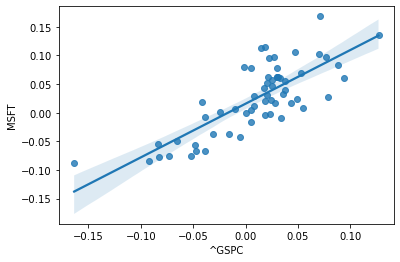

In [43]:
sns.regplot(x='^GSPC', y='MSFT', data=mly_ret)
# the line is our predicted value, accuracy only 60% as the adjusted r^2
# like when x change 5%, we predict y will change 5% too
# while there is a distribution of the y value at x = 0.05
# the line is the mean, the observed value is higher or lower than that

### Considering the risk-free rate
- famaFrench, this guy doesnt update rf data monthly
- our mly_ret has 60 rows of data, rf only has 58, doesnt match, cannot do the operation to cal the excess ret
- so we create a series to append to the rf df to fit the size
- reference: https://www.tutorialspoint.com/python-pandas-create-a-periodindex-and-set-frequency

In [56]:
import pandas as pd

In [81]:
rf = reader.DataReader('F-F_Research_Data_Factors','famafrench',start, end)[0].RF
# we dont need August
rf = rf[1:]
# only goes to June 2022, need to add 2 rows of data to match the size with mnly_ret
rf.tail()

Date
2022-02    0.00
2022-03    0.01
2022-04    0.01
2022-05    0.03
2022-06    0.06
Freq: M, Name: RF, dtype: float64

In [82]:
# not sure what benchmakr French is using for the rf
# I refer to the 3 months T-bill
# the numbers are different, but the trend is increasing
# so I assumed that they are increasing
supplement = pd.PeriodIndex(['2022-07','2022-08'],freq='M')
sup1 = pd.Series([0.07,0.08], index=supplement)
rf = rf.append(sup1)
rf.tail()

2022-04    0.01
2022-05    0.03
2022-06    0.06
2022-07    0.07
2022-08    0.08
Freq: M, dtype: float64

### Subtract rf to get excess return

In [84]:
# create new cols in the mly_ret df
mly_ret['MSFT-rf'], mly_ret['^GSPC-rf'] = mly_ret['MSFT']-rf.values, mly_ret['^GSPC']-rf.values
mly_ret.head()

Symbols,MSFT,^GSPC,MSFT-rf,^GSPC-rf
Date,,,,
2017-09-30,-0.002140,0.023252,-0.092140,-0.066748
2017-10-31,0.114864,0.018243,0.024864,-0.071757
2017-11-30,0.016984,0.028083,-0.063016,-0.051917
2017-12-31,0.021148,0.018217,-0.068852,-0.071783
2018-01-31,0.105410,0.047481,-0.014590,-0.072519


In [85]:
y = mly_ret['MSFT-rf']
x = mly_ret['^GSPC-rf']

x_sm = sm.add_constant(x)

/Users/jktrading/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [89]:
model = sm.OLS(y,x_sm)
result = model.fit()
result.summary()
# adjusted r^2 increased from 60 to 80 after deducting the rf
# why?

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                MSFT-rf   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     357.4
Date:                Wed, 03 Aug 2022   Prob (F-statistic):           1.79e-26
Time:                        21:54:18   Log-Likelihood:                 114.42
No. Observations:                  60   AIC:                            -224.8
Df Residuals:                      58   BIC:                            -220.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.006      1.598      0.116      -0.002       0.021
^GSPC-rf       0.9246      0.049     18.905      0.000       0.827       1.022
==============================================================================
Omnibus:                        5.297   Durbin-Watson:                   2.315
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                4.788
Skew:                           0.690   Prob(JB):                       0.0913
Kurtosis:                       3.100   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='^GSPC-rf', ylabel='MSFT-rf'>

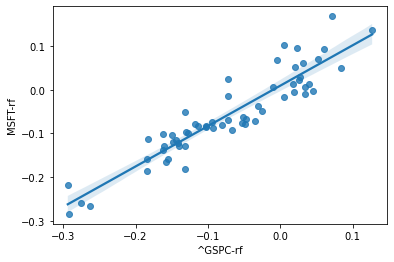

In [90]:
sns.regplot(data=mly_ret, x='^GSPC-rf', y='MSFT-rf')

### Statistical Concept Revision
- they are various ways to evaluate a regression model
- for evaluating a single model, we are looking for whether the model is statistically support there is a signgicant linear relationship between the DV and IV 
- most of them are for comaprison, so if just one sample, some of them are meaningless
- to claim statistical significance, the alpha, or the type1 error rate cannot be greater the .05, otherwise the net to capture data is too big
- df = n-(number of samples +1)
- in this case, sample is only ^GSPC, so df = 60-2 =58

R sqaure and adjusted R square
- also called the coefficient of determination
- how much variance of the dependent variable is explained by the model, or the independent variable
- =SSR/SST, so the bigger, the more explanatory power the regression model, or the line has

F- Statistics
(pending to confirm whether applicable to this case since it has only one sample)
- F is for comparing 2 sample variance, not comparing with hypothesized variance
- so in this case, it is comparing with hypothesized variance, F will be the same as t
- F=large sample varinace/smaller sample variance
- F-distribution is always upper tail test only
- need to based on the df of two samples to find the F-crit from F-dist-table
- the null hypo is sample a variance = sample b variance
- the Ha is sample a variance is > sample b variance, given sample a has a larger variance
- if F-test > F-crit, reject null, and conclude sample a and sample b has different variance
- In this case, with df = 58, F-crit = 1.5, our F-test is 357, much greater. Also can refer to the P-value of F-stats, also extremely small
- so reject the null, support that they have different vairance

AIC, BIC

Coef
- std err is the variance of our estimation, which means the estimated value is just a mean value, it also has a distribution
- how to cal it? sb1 = sqrt(MSE)/(sum(x-mean)^2)
    - x is the obeserved value, mean is the predicted value of the line, or really the mean only? pending to confirm

t-Statistics
- Null Hypo is the slope of the regression line is 0, so no significant linear relationship between the two varaibles
- |t| means the t critical value, if bigger than it, reject the null hypo
- how to interpret?
    - first, the slope of regression line is b1, which is the the independent variable's coefficient. In this case, the ^GSPC's
    - then, is it an point estimator
    - we are finding whether the interval of slope values contain 0, if contain it might has no significant linear relationship
    - for this case, No, it doesnt contain 0, can we say it has significant linear relationship at this stage?
    - No, need to see wehether t-value > t-critical value or not? so we can reject the null that the slope = 0. How to cal the t-value, and t-critical value?
    - for t = b1/sb1, 
    - sb1 = sqrt(MSE)/(sum(x-mean^2)
    - for t-crit, check t-table, refer to the degree of freedom, 58 df in t, 2-tails test is around 2
    - so our test stats t = 18, > t-critical 2, combining two observation, we can statistically reject the null
    - and support that there is a significant linear relationship between 2 variables
- Pr>|t| is the p-value for this hypothesis test. A low p-value means, that you can reject the null-hypothesis and accept the alternative hypothesis (coef!=0).
- bigger df, smaller critical value, since more samples, the estimation will be more precise, which means the distribution of value(the net) will be narrower

Confidence Interval
- point estimator for the slope +- margin of error
- margin of error = (t value)*(std of the slope)
- meaning: 95% confident that the interval contains the true slope of the regression line.
    - true slope here means the true value of b1
- observation:
    - wider at head and tail since further deviation from the mean, the wider, the more possible values
    - the the prediction of y is most accurate at mean x position
    - why? refer to the equation, part of it is (x-mean)^2. When x is deviate from the mean, it is bigger, the margin of error increases

Skew and Kurtosis
- for normal distribution, 0 skew, 3 kurtosis
- for this case, right skewed, a higher kurtosis
- kurtosis >3 means, comparing with normal dist, the distribution of the predicted y value by the regression line has more possible values at the head and tail, rather than around the mean(the line). Which means higher kurtosis leads to fatter tail of the distribution
- A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. A value between 0.5 and 1 or -0.5 and -1 is moderately skewed. A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.
- for this case, skewness is 0.6, comparing with normal dist, more observed values is higher than the predicted value, given the regression line is already the best fit line we can find